【参考】Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, Third Edition, O'Reilly Media Inc. 　(邦訳)scikit-learn、Keras、TensorFlowによる実践機械学習 第2版

MNISTのデータセットをダウンロードします。
ダウンロードされたデータを、変数mnistに格納しておきます。

In [44]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

dataには、数字の画像データが入っています。データは、Numpyの2次元配列です。
mnist.data.shapeには、データの「形」が入っています。(70000, 784)は、700000文字分のデータが入っていて、各文字（数字）は784次元の配列で表されていることをしまします。

In [2]:
mnist.data.shape

(70000, 784)

最初の数字のデータを表示します。
784要素は、28x28ピクセルのモノクロイメージを表しています。（白=0, 黒=255）

In [4]:
mnist.data[1]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  51., 159., 253., 159.,  50.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

イメージを表示してみましょう。
次のコードの mnist.data[55] の55に、0~69999 の数字を入れて、いろいろなイメージを確認してみてください。

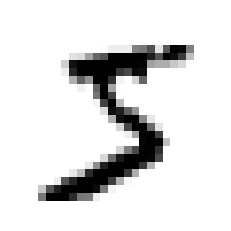

In [28]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = mnist.data[0]
plot_digit(some_digit)
plt.show()

mnist.targetは、70000要素のNumpy 1次元配列で、mnist.dataの画像イメージが実際どの数字であるか（正解データ、ラベル）が格納されています。mnist.data[0]の正解がmnist.target[0],...,mnist.data[69999]の正解がmnist.target[69999]というふうに対応づけられています。

例えば、mnist.data[55]のイメージの正解は、mnist.target[55]です（=8）。

In [21]:
print(mnist.target.shape)
print('\n')
print(mnist.target)
print('\n')
print(mnist.target[55])

(70000,)


['5' '0' '4' ... '4' '5' '6']


8


機械学習では、説明変数（ここでは画像イメージ）をX、目的変数（正解データ）をyとすることが多いので、X, Yにデータを代入しておきます。

In [23]:
X = mnist.data
y = mnist.target

データを、学習用とテスト用に分割します。<br>
【Q】 データを学習用とテスト用に分割する理由はなんでしょう？

In [24]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [25]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [26]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [48]:
print(np.where(sgd_clf.predict(X[0:1000])))
print(np.where(y[0:1000]=='5'))

(array([  0,  11,  35,  47,  48,  65,  81, 100, 125, 142, 145, 173, 175,
       182, 191, 202, 219, 228, 236, 239, 255, 259, 262, 266, 273, 284,
       287, 306, 316, 328, 332, 335, 376, 396, 403, 407, 417, 420, 433,
       437, 451, 463, 469, 470, 474, 480, 496, 502, 504, 512, 513, 514,
       516, 517, 523, 528, 537, 540, 543, 544, 559, 561, 576, 579, 614,
       615, 620, 622, 625, 652, 653, 679, 689, 699, 715, 719, 722, 731,
       745, 748, 751, 757, 767, 768, 769, 771, 775, 789, 790, 799, 805,
       811, 815, 837, 843, 845, 849, 857, 859, 861, 867, 874, 879, 886,
       889, 895, 903, 912, 915, 921, 924, 927, 947, 949, 956, 957, 960,
       964, 970, 985]),)
(array([  0,  11,  35,  47,  65, 100, 132, 138, 145, 173, 175, 182, 191,
       219, 236, 239, 244, 259, 266, 273, 278, 284, 287, 306, 316, 328,
       332, 335, 376, 396, 403, 407, 417, 420, 437, 463, 474, 480, 496,
       502, 504, 512, 513, 514, 516, 523, 537, 543, 544, 554, 579, 610,
       614, 620, 622, 625, 635, 652, 

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [50]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # prints False: no 5s detected

False


In [51]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [53]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [56]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train) 

SVC(random_state=42)

In [59]:
print(svm_clf.predict(X[0:50]))
print(y[0:50])

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9' '4' '0' '9' '1' '1' '2' '4' '3' '2' '7' '3' '8' '6' '9' '0' '5'
 '6' '0' '7' '6' '1' '8' '7' '9' '3' '9' '8' '5' '3' '3']
['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9' '4' '0' '9' '1' '1' '2' '4' '3' '2' '7' '3' '8' '6' '9' '0' '5'
 '6' '0' '7' '6' '1' '8' '7' '9' '3' '9' '8' '5' '9' '3']
